In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import os
import pandas as pd
from sklearn.metrics import accuracy_score
import torchvision.transforms as transforms
import torchvision.models as models
import pickle
from statistics import mean
import torch.nn as nn 
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from torchvision.datasets import CelebA
from torch.utils.data import DataLoader, Dataset
from shared_interest.shared_interest import shared_interest
from shared_interest.util import flatten, binarize_std, normalize_0to1
from interpretability_methods.gradcam import GradCAM

In [11]:
class CelebADatasetHQ(Dataset):
    def __init__(self, root, image_transform = None, ground_truth_transform = None):
        self.root = root
        self.img_dir = self.root + 'img_align_celeba'
        self.mask_dir = self.root + 'CelebAMask-HQ/'
        self.images = pd.read_csv(os.path.join(self.mask_dir, "CelebA-HQ-to-CelebA-mapping.txt"))
        
        self.image_transform = image_transform
        self.ground_truth_transform = ground_truth_transform
        self.hq_mapping = pd.read_csv(self.mask_dir + "CelebA-HQ-to-CelebA-mapping.txt", delimiter="\s+", engine="python", header=0)
        self.features = ['hair', 'eye', 'mouth', 'neck', 'nose', 'skin', 'cloth']
        
        # organizing attributes
        self.attributes = pd.read_csv(os.path.join(self.mask_dir, "CelebAMask-HQ-attribute-anno.txt"))
        self.attribute_names = ['filename'] + self.attributes.iloc[0][0].split()
        self.attributes.column = self.attributes.iloc[0]
        self.attributes = self.attributes[1:].reset_index(drop=True)
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        image_path = os.path.join(self.img_dir, self.images.iloc[idx][0].split()[2])
        image = Image.open(image_path)
        ground_truth = {}
        
        attribute = self.attributes.iloc[idx][0].split()
        black_hair = max(0, int(attribute[self.attribute_names.index('Black_Hair')]))
        blond_hair =  max(0, int(attribute[self.attribute_names.index('Blond_Hair')]))
        smiling =  max(0, int(attribute[self.attribute_names.index('Smiling')]))
        
        for feature in self.features:
            feature_ground_truth = self._create_feature_ground_truth(idx, feature)
            if  self.ground_truth_transform is not None:
                ground_truth[feature] = self.ground_truth_transform(feature_ground_truth).squeeze(0)
            else:
                ground_truth[feature] = feature_ground_truth.squeeze(0)
            
        if self.image_transform is not None:
            image = self.image_transform(image)
            
        return image, ground_truth, black_hair, blond_hair, smiling
    
    def _create_feature_ground_truth(self, hq_idx, feature):
        features = []
        if feature == 'eye':
            features.extend(['l_brow', 'r_brow', 'l_eye', 'r_eye'])
        elif feature == 'mouth':
            features.extend(['l_lip', 'u_lip', 'mouth'])
        else:
            features.append(feature)
        
        folder = self._get_folder(hq_idx) + "/"
        mask_path = self.mask_dir + '/CelebAMask-HQ-mask-anno/' + folder + f"{hq_idx:05}"
        
        # make empty ground truth 
        feature_ground_truth = torch.zeros([512,512])
        for selected_feature in features:
            mask_file = mask_path + "_" + selected_feature + ".png"
            if (os.path.exists(mask_file)):
                mask_image = Image.open(mask_file)
                to_tensor = transforms.Compose([transforms.ToTensor(),])
                feature_ground_truth = torch.add(to_tensor(mask_image)[0], feature_ground_truth)
                feature_ground_truth[feature_ground_truth!=0] = 1

        return feature_ground_truth
    
    def _get_folder(self, hq_idx):
        # getting idx of celeba-hq                                       
        folder = ""
        if hq_idx in range(0, 2000):
            folder = "0"
        elif hq_idx in range(2000, 4000):
            folder = "1"
        elif hq_idx in range(4000, 6000):
            folder = "2"
        elif hq_idx in range(6000, 8000):
            folder = "3"
        elif 8000 <= hq_idx < 10000:
            folder = "4"
        elif 10000 <= hq_idx < 12000:
            folder = "5"
        elif 12000 <= hq_idx < 14000:
            folder = "6"
        elif 14000 <= hq_idx < 16000:
            folder = "7"
        elif 16000 <= hq_idx < 18000:
            folder = "8"
        elif 18000 <= hq_idx < 20000:
            folder = "9"
        elif 20000 <= hq_idx < 22000:
            folder = "10"
        elif 22000 <= hq_idx < 24000:
            folder = "11"
        elif 24000 <= hq_idx < 26000:
            folder = "12"
        elif 26000 <= hq_idx < 28000:
            folder = "13"
        elif 28000 <= hq_idx < 30000:
            folder = "14"
        return folder

In [12]:
def ax_off(ax):
    ax.tick_params(
        which='both',
        bottom=False,
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labeltop=False,
        labelleft=False,
        labelright=False,
    )

In [13]:
# general transforms
image_transform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224), transforms.ToTensor()])
ground_truth_transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize(256, Image.NEAREST),
                                             transforms.CenterCrop(224), transforms.ToTensor()])
reverse_image_transform = transforms.Compose([transforms.ToPILImage(),])

  2%|███▎                                                                                                                                    | 731/30000 [02:12<1:28:44,  5.50it/s]


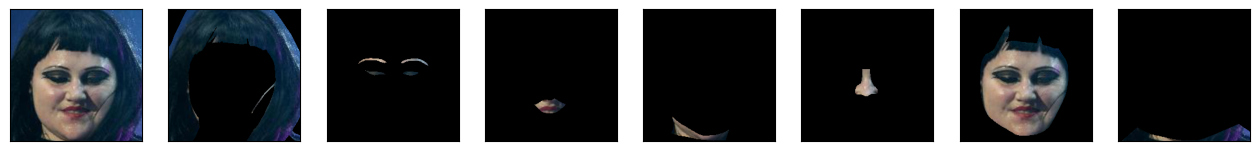

In [28]:
celeba_dir = '' # TODO: add your celeba-hq directory here.
test_dataset = CelebADatasetHQ(celeba_hq_dir, image_transform = image_transform, ground_truth_transform = ground_truth_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(16, 3))
np.vectorize(ax_off)(ax)
for idx, (image, ground_truth, black_hair, blond_hair, smiling) in enumerate(tqdm(test_dataset)):
    i = 1
    for feature in ground_truth:
        masked_image_hair = image * ground_truth[feature]
        ax[0].imshow(image.permute(1,2,0))
        ax[i].imshow(reverse_image_transform(masked_image_hair))
        i += 1
    break

In [ ]:
test_black_smiling = []
test_black_not_smiling = []
test_blond_smiling = []
test_blond_not_smiling = []

for idx, (image, ground_truth, black_hair, blond_hair, smiling) in enumerate(tqdm(test_dataset)):
    if len(ground_truth) > 0:
        if black_hair and smiling:
            test_black_smiling.append(idx)
        elif black_hair and not smiling:
            test_black_not_smiling.append(idx)
        elif blond_hair and smiling:
            test_blond_smiling.append(idx)
        elif blond_hair and not smiling:
            test_blond_not_smiling.append(idx)
        
print (len(test_black_smiling))
print (len(test_black_not_smiling))
print (len(test_blond_smiling))
print (len(test_blond_not_smiling))

In [9]:
# unbiased test dataset
unbiased_black_smiling = random.sample(test_black_smiling, 2000)
unbiased_blond_not_smiling = random.sample(test_blond_not_smiling, 2000)

unbiased_black_not_smiling = random.sample(test_black_not_smiling, 2000)
unbiased_blond_smiling = random.sample(test_blond_smiling, 2000)
unbiased_samples = unbiased_black_smiling + unbiased_blond_not_smiling + unbiased_black_not_smiling + unbiased_blond_smiling
len(unbiased_samples)

8000

In [10]:
# unbiased test dataset
# get these from biased_samples (black smiling and blond not smiling) 
biased_black_smiling = unbiased_black_smiling.copy()
biased_blond_not_smiling = unbiased_blond_not_smiling.copy()

biased_black_not_smiling = random.sample(unbiased_black_not_smiling, 500)
biased_blond_smiling = random.sample(unbiased_blond_smiling, 500)
biased_samples = biased_black_smiling + biased_blond_not_smiling + biased_black_not_smiling + biased_blond_smiling
len(biased_samples)

5000

In [13]:
biased_test = torch.utils.data.Subset(test_dataset, biased_samples)
unbiased_test = torch.utils.data.Subset(test_dataset, unbiased_samples)

In [14]:
biased_test_loader = torch.utils.data.DataLoader(biased_test, batch_size=64, shuffle=True)
unbiased_test_loader = torch.utils.data.DataLoader(unbiased_test, batch_size=64, shuffle=True)

In [10]:
def binarize_threshold(batch, threshold):
    batch_normalized = normalize_0to1(batch)
    binary_mask = (batch_normalized >= threshold).astype('uint8')
    return binary_mask

In [33]:
def test(seed, model, device, test_loader, model_type, test_type):
    model.eval()
    criterion = nn.CrossEntropyLoss(reduction="sum")
    saliency_method = GradCAM(model, model.layer4[2])
    correct = 0
    
    salient_pixel_count = 0
    total_iou_coverage = {}
    total_pointing_game = {}
    features = ['hair', 'eye', 'mouth', 'neck', 'nose', 'skin', 'cloth']
    
    for feature in features:
        total_iou_coverage[feature] = np.array([])
        total_pointing_game[feature] = np.array([])
   
    for batch_idx, (image, ground_truth, black_hair, blond_hair, smiling) in enumerate(tqdm(test_loader)):
        with torch.no_grad():
            image = image.to(device)
            label = smiling.to(device)

            output = model(image)
            pred = torch.max(output, dim=-1)[1]
            correct += (pred==label).sum().item()

        saliency = flatten(saliency_method.get_saliency(image))
        saliency_masks = binarize_threshold(saliency, 0.5)

        for feature in ground_truth:
            salient_pixel_count = 0
            feature_ground_truth = ground_truth[feature].numpy()
            iou_coverage = shared_interest(feature_ground_truth, saliency_masks, score='iou_coverage')
            total_iou_coverage[feature] = np.concatenate((total_iou_coverage[feature], iou_coverage))

            for j in range(saliency.shape[0]):
                saliency_batch = saliency[j]
                ground_truth_batch = feature_ground_truth[j]
                pixel = np.unravel_index(saliency_batch.argmax(), saliency_batch.shape)
                point = ground_truth_batch[pixel[0], pixel[1]]

                # check if most salient feature is in ground truth 
                if point > 0:
                    salient_pixel_count += 1
            pointing_game = salient_pixel_count / len(test_loader.dataset)
            total_pointing_game[feature] = pointing_game

    accuracy = 100. * correct / len(test_loader.dataset)
    print('Accuracy: %.2f' %accuracy)
    
    print ("Pointing Game: ")
    for feature in features:
        print(feature + ': ' + str(total_pointing_game[feature]))
    
    print ("IoU Coverage: ")
    for feature in features:
        print(feature + ': ' + str(mean(total_iou_coverage[feature])))

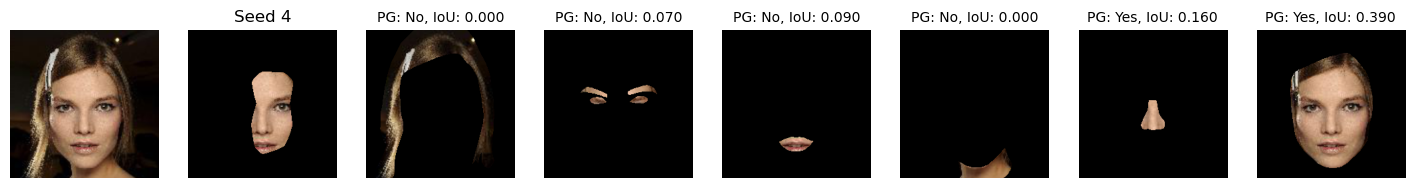

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(18, 8))
np.vectorize(ax_off)(ax)
fig_images = [4]

device = torch.device("cuda" if torch.cuda.is_available() else  "cpu")
fig_index = 0 
model_path = ''

for i, (image, ground_truth, black_hair, blond_hair, smiling) in enumerate(test_dataset):
    ground_truth.pop("cloth")
    if i in fig_images:
        ax[fig_index].imshow(image.permute(1,2,0))
        ax[fig_index].set(frame_on=False)
        if black_hair and smiling:
            ax[fig_index].set_title('Black hair & smiling', fontsize = 10)
        elif black_hair and not smiling:
            ax[fig_index].set_title('Black hair & not smiling', fontsize = 10)
        elif blond_hair and smiling:
            ax[fig_index].set_title('Blond hair & smiling', fontsize = 10)
        elif blond_hair and not smiling:
            ax[fig_index].set_title('Blond hair & not smiling', fontsize = 10)
        
        seed = 4
        unbiased_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(device)
        unbiased_model.load_state_dict(torch.load(model_path))
        saliency_method = GradCAM(unbiased_model, unbiased_model.layer4[2])

        saliency = flatten(saliency_method.get_saliency(image.to(device).unsqueeze(0)))
        saliency_masks = binarize_threshold(saliency, 0.5)

        saliency_image = np.array(image.permute(1,2,0)) * np.expand_dims(saliency_masks[0], axis=2)
        fig_index += 1  
        ax[fig_index].imshow(saliency_image)
        ax[fig_index].set_title('Seed ' + str(seed))
        ax[fig_index].set(frame_on=False)
        
        for feature in ground_truth:
            fig_index += 1

            masked_image_hair = image * ground_truth[feature]
            ax[fig_index].imshow(reverse_image_transform(masked_image_hair))
            ax[fig_index].set(frame_on=False)
            feature_ground_truth = ground_truth[feature].unsqueeze(0).numpy()
            iou_coverage = shared_interest(feature_ground_truth, saliency_masks, score='iou_coverage')

            for j in range(saliency.shape[0]):
                saliency_batch = saliency[j]
                ground_truth_batch = feature_ground_truth[j]
                pixel = np.unravel_index(saliency_batch.argmax(), saliency_batch.shape)
                point = ground_truth_batch[pixel[0], pixel[1]]

                # check if most salient feature is in ground truth 
                if point > 0:
                    ax[fig_index].set_title('PG: Yes, IoU: %.2f0'%(iou_coverage[0]), fontsize = 10)
                else: 
                    ax[fig_index].set_title('PG: No, IoU: %.2f0'%(iou_coverage[0]), fontsize = 10)
        break